# Trabalho de Validação de modelos de clusterização [22E4_3]

### Prof: Luiz Fernando de Frias
### Aluno: João Paulo Barros Guimarães Mendes

O trabalho visa clusterizar cidades de acordo com seus índices populacionais (média de alunos por sala de aula), aprovação e desempenho no provão de Língua Portuguesa e Matemática do ano de 2021 (ainda não foram disponibilizados dados de 2022).
    
Esta primeira versão trabalha apenas com escolas de ensino médio.
    
Agrupar estados e/ou cidades contribui para facilitar e agilizar a disponibilização de recursos financeiros na melhoria dos índices escolares pelo senado federal e consequentemente os legislativos estaduais.

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN

### Importando dados de população escolar

In [2]:
df1 = pd.read_excel('./ATU_2021_ESCOLAS/ATU_ESCOLAS_2021.xlsx', header=5, 
                    na_values=['--', '', ' '], 
                    decimal='.')

# Dropando colunas irrelevantes

df1 = pd.concat([df1[df1.columns[:9]], df1[df1.columns[-5:-2]]], 
                axis=1)

# Filtrando apenas instituições de ensino médio com os 3 anos

df1.dropna(subset=list(df1.columns[-3:]), 
           axis=0, 
           how='any', 
           inplace=True)

# Renomeando colunas

df1.rename(columns={'Unnamed: 26': 'pop_1_ano', 
                    'Unnamed: 27': 'pop_2_ano', 
                    'Unnamed: 28': 'pop_3_ano'}, inplace=True)

# Tirando linhas irrelevantes
df1 = df1.loc[3:]

In [3]:
# Renomeando colunas

df1.columns=['ano', 'regiao', 'uf', 'cod_municipio', 'nome_municipio', 'cod_escola', 
             'nome_escola', 'localizacao', 'dependencia_adm', 'pop_1_ano', 'pop_2_ano', 'pop_3_ano']

# Dropando coluna 'ano' visto que a análise só trata do ano de 2021

df1.drop('ano', axis=1, inplace=True)

In [4]:
df1.shape

(26979, 11)

### Importando dados de qualidade escolar

In [5]:
df2 = pd.read_excel('./divulgacao_ensino_medio_escolas_2021/divulgacao_ensino_medio_escolas_2021.xlsx', 
                    header=6, 
                    na_values=['--', '-', '', ' ', 'ND'], 
                    decimal='.')

new_columns_names = list(df2.columns[:7]) + \
                    list(df2.loc[1][df2.columns[7:-4]].values) + \
                    list(df2.loc[0][df2.columns[-4:-1]].values)

# Renomenando colunas
df2.drop(df2.columns[-1], axis=1, inplace=True)

df2.columns = new_columns_names

# Renomeando novamente as colunas

df2.columns = ['uf', 'cod_municipio', 'nome_municipio', 'cod_escola', 'nome_escola', 
               'rede', 'taxa_aprovacao', 'aprov_1_ano', 'aprov_2_ano', 'aprov_3_ano', 
               'aprov_4_ano', 'indicador_rendimento', 'matematica', 'portugues', 'nota_media_padronizada']

df2 = df2[3:]

df2.dropna(subset=['matematica', 'portugues', 'aprov_1_ano', 'aprov_2_ano', 'aprov_3_ano'], 
           how='any', 
           inplace=True)

df2.drop('aprov_4_ano', axis=1, inplace=True)

In [6]:
df2.shape

(7145, 14)

In [7]:
df2.head()

,uf,cod_municipio,nome_municipio,cod_escola,nome_escola,rede,taxa_aprovacao,aprov_1_ano,aprov_2_ano,aprov_3_ano,indicador_rendimento,matematica,portugues,nota_media_padronizada
3,RO,1100015,Alta Floresta D'Oeste,11024682,EEEFM EURIDICE LOPES PEDROSO,Estadual,90.8,89.3,86.3,98.9,0.91194,246.73,250.12,3.899135
4,RO,1100015,Alta Floresta D'Oeste,11024968,EEEMTI JUSCELINO KUBITSCHEK DE OLIVEIRA,Estadual,98.9,98.6,98.4,100,0.989949,298.17,302.78,5.40993
6,RO,1100023,Ariquemes,11006773,EEEFM CORA CORALINA,Estadual,71.4,44.8,69.4,90,0.627067,266.5,269.69,4.469767
8,RO,1100023,Ariquemes,11007168,COLEGIO TIRADENTES DA POLICIA MILITAR - CTPM III,Estadual,97.9,96.9,100,96.6,0.978094,264.88,281.56,4.624709
10,RO,1100023,Ariquemes,11007893,EEEFM RICARDO CANTANHEDE,Estadual,95.7,97.1,93.7,96.4,0.957107,262.78,266.48,4.369466


### Importando dados de renda per capita

In [8]:
df3 = pd.read_excel('pib_municipios_2020.xls').query('Ano==2020')\
[['Código do Município', 'Produto Interno Bruto per capita, \na preços correntes\n(R$ 1,00)']]

In [9]:
df3.columns = ['cod_municipio', 'pib_percapita']
df3['cod_municipio'] = df3['cod_municipio'].astype(str)

### Concatenando os dataframes

In [10]:
# Checando intersecção de colunas

np.intersect1d(df1.columns, df2.columns)

array(['cod_escola', 'cod_municipio', 'nome_escola', 'nome_municipio',
       'uf'], dtype=object)

In [11]:
df2.head(2)

,uf,cod_municipio,nome_municipio,cod_escola,nome_escola,rede,taxa_aprovacao,aprov_1_ano,aprov_2_ano,aprov_3_ano,indicador_rendimento,matematica,portugues,nota_media_padronizada
3,RO,1100015,Alta Floresta D'Oeste,11024682,EEEFM EURIDICE LOPES PEDROSO,Estadual,90.8,89.3,86.3,98.9,0.91194,246.73,250.12,3.899135
4,RO,1100015,Alta Floresta D'Oeste,11024968,EEEMTI JUSCELINO KUBITSCHEK DE OLIVEIRA,Estadual,98.9,98.6,98.4,100,0.989949,298.17,302.78,5.40993


In [288]:
df_final = \
df1.merge(df2.drop(['cod_municipio', 'nome_escola', 
                    'nome_municipio', 'uf'], axis=1), 
          on='cod_escola', how='inner')

df_final['cod_municipio'] = df_final['cod_municipio'].astype(str)

df_final = df_final.merge(df3, on='cod_municipio', how='left')

### Preprocessamento para aplicação do modelo

In [289]:
df_final.nunique()

regiao                       5
uf                          26
cod_municipio             2907
nome_municipio            2820
cod_escola                7145
nome_escola               6991
localizacao                  2
dependencia_adm              3
pop_1_ano                  376
pop_2_ano                  366
pop_3_ano                  349
rede                         3
taxa_aprovacao             289
aprov_1_ano                326
aprov_2_ano                343
aprov_3_ano                229
indicador_rendimento      4165
matematica                4792
portugues                 4695
nota_media_padronizada    7132
pib_percapita             2907
dtype: int64

Existe mais código de município do que nome de município. Isto porque alguns municípios são homônimos. Portanto, é boa prática concatenar o nome do município com a sigla da UF.

In [290]:
df_final['nome_municipio'] = df_final['nome_municipio'] + ' - ' + df_final['uf']

In [291]:
# Usaremos apenas algumas colunas, como dito no rodapé do projeto.

df_final = df_final[['cod_municipio', 'localizacao', 'pop_1_ano', 'pop_2_ano', 'pop_3_ano', 
          'aprov_1_ano', 'aprov_2_ano', 'aprov_3_ano',  
          'matematica', 'portugues', 'pib_percapita']]

df_final = pd.concat([df_final, pd.get_dummies(df_final['localizacao'])], axis=1)\
             .rename(columns={'Rural': 'rural', 'Urbana': 'urbana'})

df_final2 = df_final.groupby('cod_municipio').agg({'pop_1_ano': 'mean', 
                                                   'pop_2_ano': 'mean', 
                                                   'pop_3_ano': 'mean', 
                                                   'aprov_1_ano': 'mean', 
                                                   'aprov_2_ano': 'mean', 
                                                   'aprov_3_ano': 'mean', 
                                                   'matematica': 'mean', 
                                                   'portugues': 'mean', 
                                                   'pib_percapita': 'first', 
                                                   'rural': 'sum', 
                                                   'urbana': 'sum'}).fillna(0).reset_index()

In [292]:
df_final2['perc_escola_urbana'] = df_final2['urbana']/(df_final2['urbana']+df_final2['rural'])

In [293]:
df_final2.drop(['rural', 'urbana'], axis=1, inplace=True)

In [294]:
df_final2.head()

,cod_municipio,pop_1_ano,pop_2_ano,pop_3_ano,aprov_1_ano,aprov_2_ano,aprov_3_ano,matematica,portugues,pib_percapita,perc_escola_urbana
0,1100015,19.150000,22.15,18.250000,93.95,92.35,99.450000,272.450,276.450000,25091.18,1.0
1,1100023,27.866667,24.60,27.766667,79.60,87.70,94.333333,264.720,272.576667,25730.20,1.0
2,1100049,25.200000,25.65,21.650000,98.75,97.60,100.000000,263.820,268.245000,29331.29,1.0
3,1100080,22.350000,28.00,21.650000,84.05,87.05,94.050000,272.030,275.450000,13936.50,0.5
4,1100098,31.850000,35.35,28.550000,100.00,100.00,100.000000,266.575,265.100000,20380.20,1.0


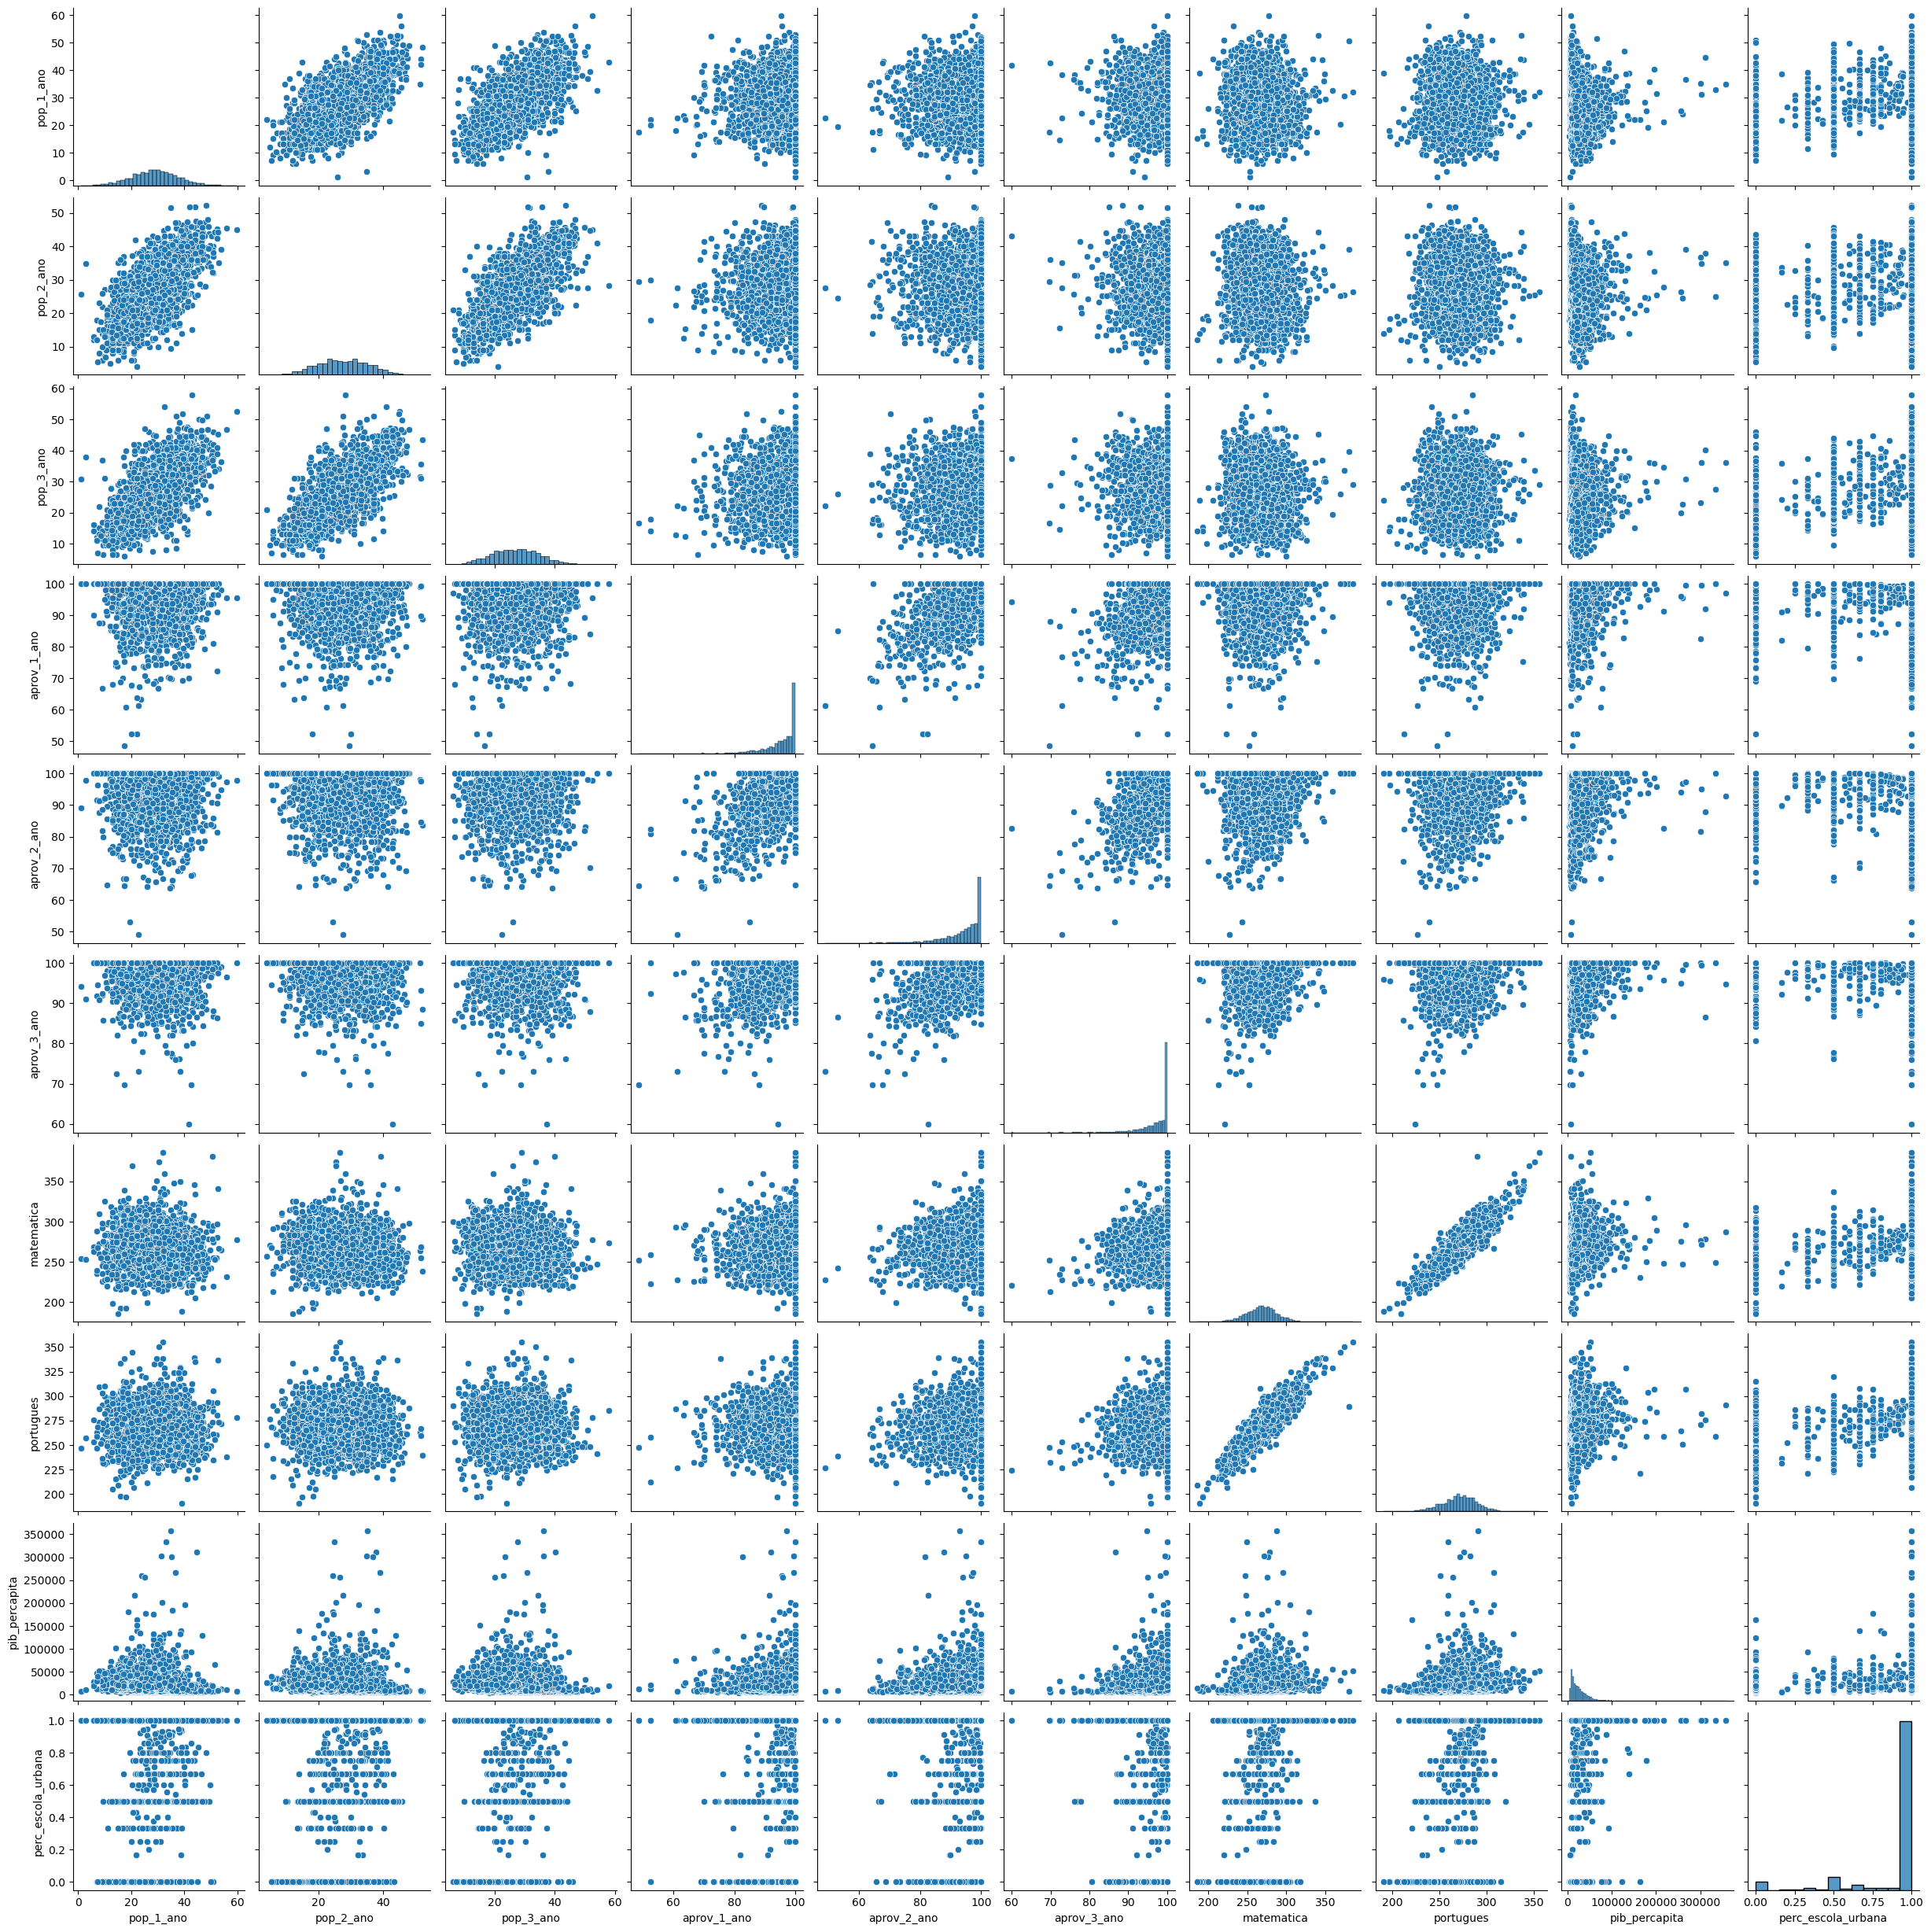

In [295]:
sns.pairplot(df_final2.drop(['cod_municipio'], axis=1));

    Analisando o pairplot dá para ver que as variáveis não mostram correlações, exceto nas provas de matemática e português onde as escolas que tendem a ir bem numa disciplina também vão bem na outra e vice-versa. A clusterização será difícil neste cenário.

In [296]:
df_final2.nunique()

cod_municipio         2907
pop_1_ano              911
pop_2_ano              893
pop_3_ano              894
aprov_1_ano            771
aprov_2_ano            815
aprov_3_ano            615
matematica            2639
portugues             2614
pib_percapita         2907
perc_escola_urbana      44
dtype: int64

In [297]:
X = df_final2.drop('cod_municipio', axis=1)

In [298]:
sc = StandardScaler()
X = sc.fit_transform(X)

### Aplicando KMeans

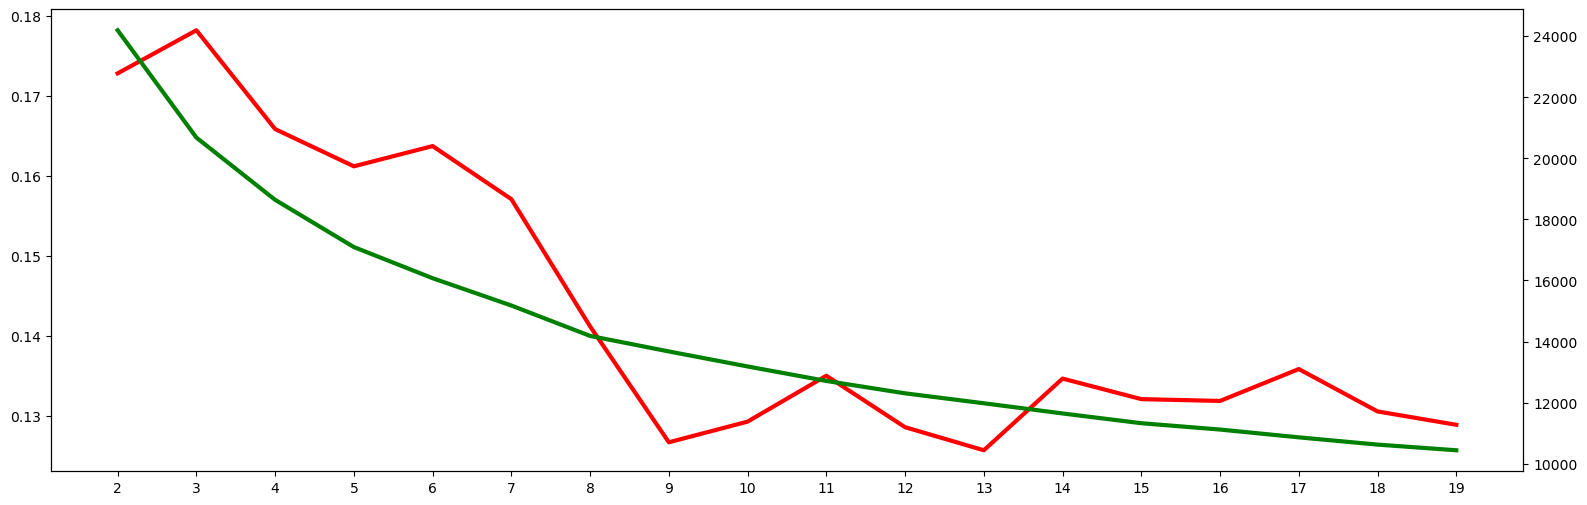

In [299]:
sil_scores = {}
inertias = {}
total_clusters = 20

for k in range(2, total_clusters):
    
    kmeanModel = KMeans(n_clusters=k).fit(X)
    clusters = kmeanModel.predict(X)
    
    inertias[k]=kmeanModel.inertia_
    sil_scores[k]=silhouette_score(X, clusters)
    
plt.figure(figsize=(19,6));
plt.xticks(ticks=list(inertias.keys()), labels=list(inertias.keys()))
sns.lineplot(sil_scores, markers=True, linewidth=3, color='red');
ax2 = plt.twinx()
sns.lineplot(inertias, markers=True, linewidth=3, color='green');

    Pelo método da silhueta, suspeita-se 3 clusters
    Usando o método do cotovelo para auxiliar, a escolha ficaria em 6 clusters, sendo aceitável parar em 3 clusters como indicado por silhueta (e também simplificando o problema de negócio).

In [300]:
kmeans = KMeans(n_clusters=3).fit(X)

In [301]:
pca_x = PCA(n_components=2, random_state=48).fit_transform(X)

In [302]:
df_final2['cluster'] = kmeans.predict(X)

pca_df = pd.DataFrame(data=pca_x, 
                      columns=['c1', 'c2'])

pca_df['cod_municipio'] = df_final2['cod_municipio']
pca_df['cluster'] = df_final2['cluster']

In [303]:
pca_df.head()

,c1,c2,cod_municipio,cluster
0,-1.530301,0.706801,1100015,2
1,0.860743,2.103735,1100023,0
2,-0.994546,-0.360950,1100049,2
3,0.142014,2.389948,1100080,0
4,0.367551,-1.448921,1100098,1


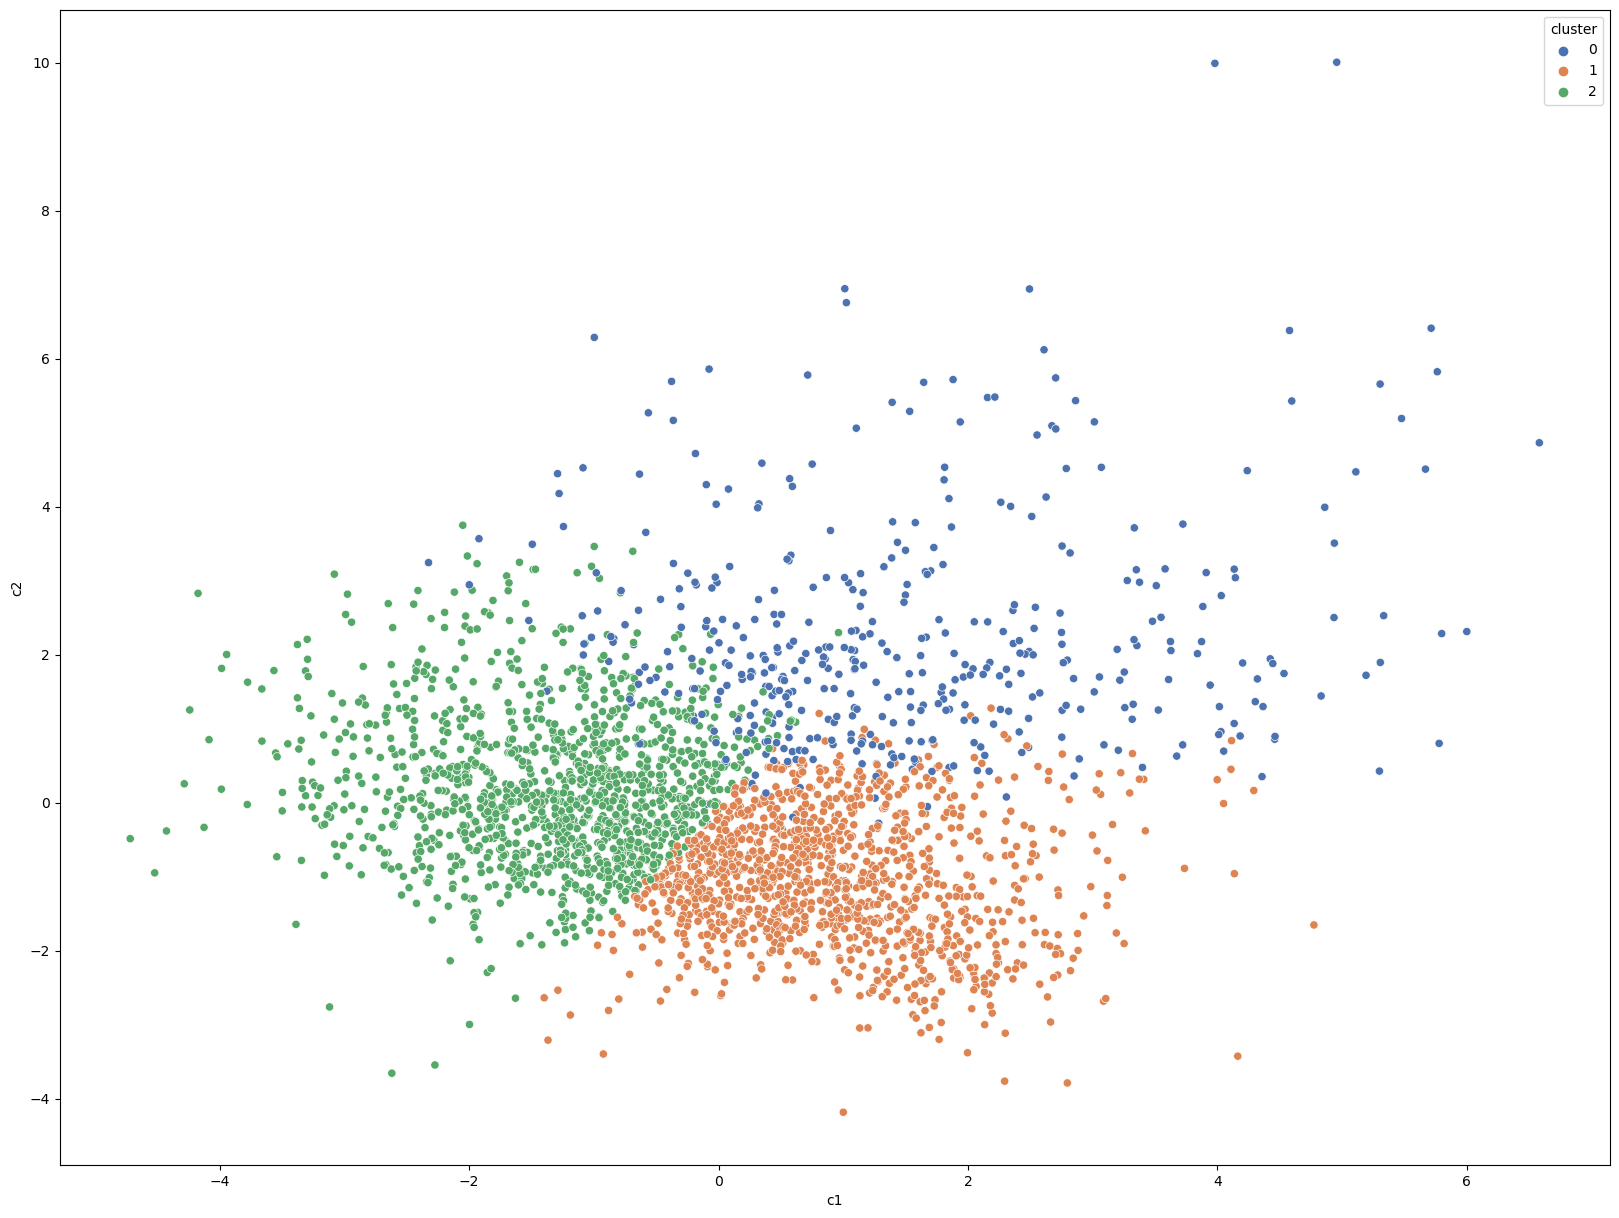

In [305]:
plt.figure(figsize=(20,15));

sns.scatterplot(data=pca_df, x='c1', y='c2', hue='cluster', markers='cod_escola', palette='deep');

In [306]:
df_final2.groupby('cluster').mean().T

cluster,0,1,2
pop_1_ano,30.562771,34.818409,23.343193
pop_2_ano,28.692737,33.640485,21.630991
pop_3_ano,27.878792,32.757975,21.274145
aprov_1_ano,85.287417,97.156666,96.893069
aprov_2_ano,83.994223,96.495900,96.410757
aprov_3_ano,91.253201,98.342147,98.459890
matematica,262.691519,267.885186,272.212546
portugues,266.574063,271.742003,273.122390
pib_percapita,26169.529247,22733.950738,32409.379667
perc_escola_urbana,0.880227,0.942025,0.868814


    Temos o Cluster 0 como de mais baixa aprovação e mais baixas notas tanto em Matemática quanto em Português.
    Os clusters 1 e 2 se confundem um pouco nas notas e aprovações (sendo mais altas do que no cluster 0), se diferenciando agudamente nas médias populacionais em sala de aula.

### Aplicação de DBSCAN

    Como podemos ver no gráfico anterior com PCA=2, o cluster 0 (baixa nota e média população) é bastante disperso. 
    Como KMeans não detecta outliers nestes clusters, é importante analisar o resultado com DBSCAN.
    
    Como "rule of thumb", podemos usar o minPoints como Dim - 1.
    
    Epsilon, por sua vez, será escolido como o cotovelo do gráfico nas distâncias entre cada Dim*2 vizinhos.
    
    Fonte (https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html) 

In [307]:
Dim = X.shape[1]

In [308]:
# Calculando distância entre cada par de pontos

neigh = NearestNeighbors(n_neighbors=Dim-1)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

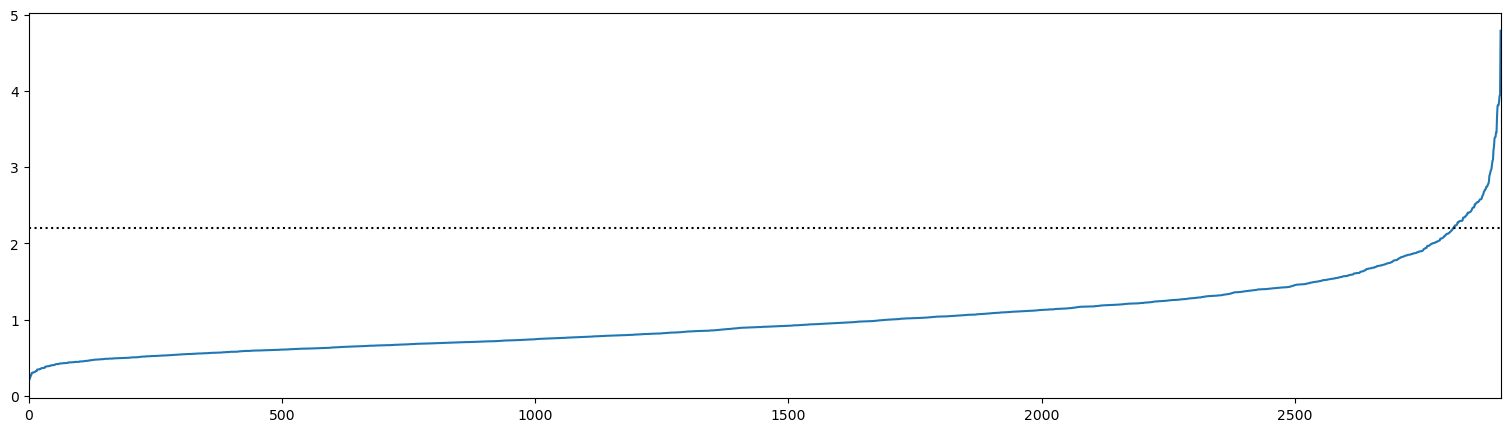

In [309]:
plt.figure(figsize=(19,5));
plt.plot(distances);
plt.axhline(2.2, color='k', ls=':');
plt.xlim(0, distances.shape[0]);

In [310]:
db = DBSCAN(eps=2.2, min_samples=2*Dim)
db.fit(X)
clusters_db = db.labels_
pca_df['cluster_db'] = clusters_db

In [311]:
pca_df['cluster_db'].value_counts()

 0    2717
-1     190
Name: cluster_db, dtype: int64

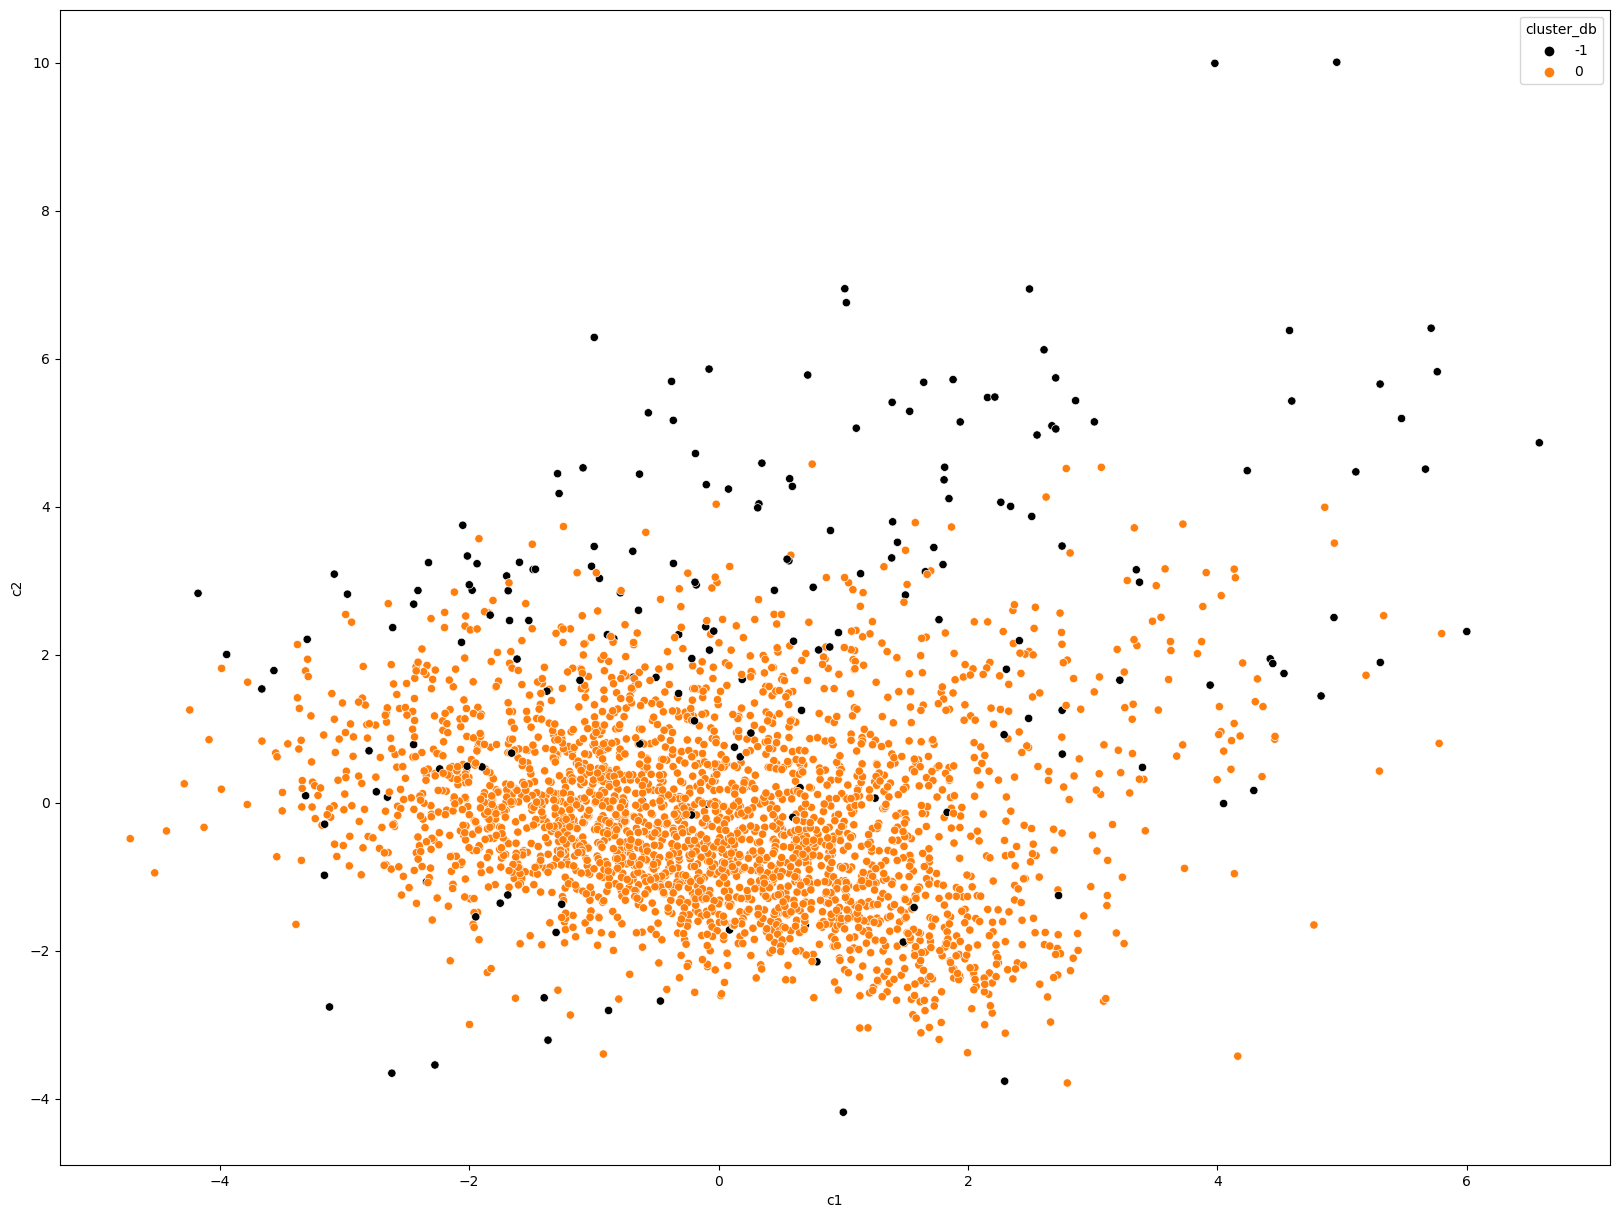

In [315]:
plt.figure(figsize=(20,15))
sns.scatterplot(pca_df, x='c1', y='c2', hue='cluster_db', palette=['k', 'tab:orange']);

    Como visto, DBSCAN não é uma boa escolha visto que existem muitos pontos aglomerados (muitas cidades com resultados parecidos), e por ser baseado em densidade, este acaba por aglomerar muitos pontos ao cluster, quase que "crescendo desordenadamente" e deixando apenas alguns pontos como outlier.
    Neste caso podemos interpretar que algumas escolas fogem ao padrão do cluster único e só.
        
    Uma alternativa é a marcação de outliers com DBSCAN e consequentemente clusterização por KMeans.
    
    Em nosso caso, isto é facilmente resolvido filtrando os valores -1 em cluster_db   

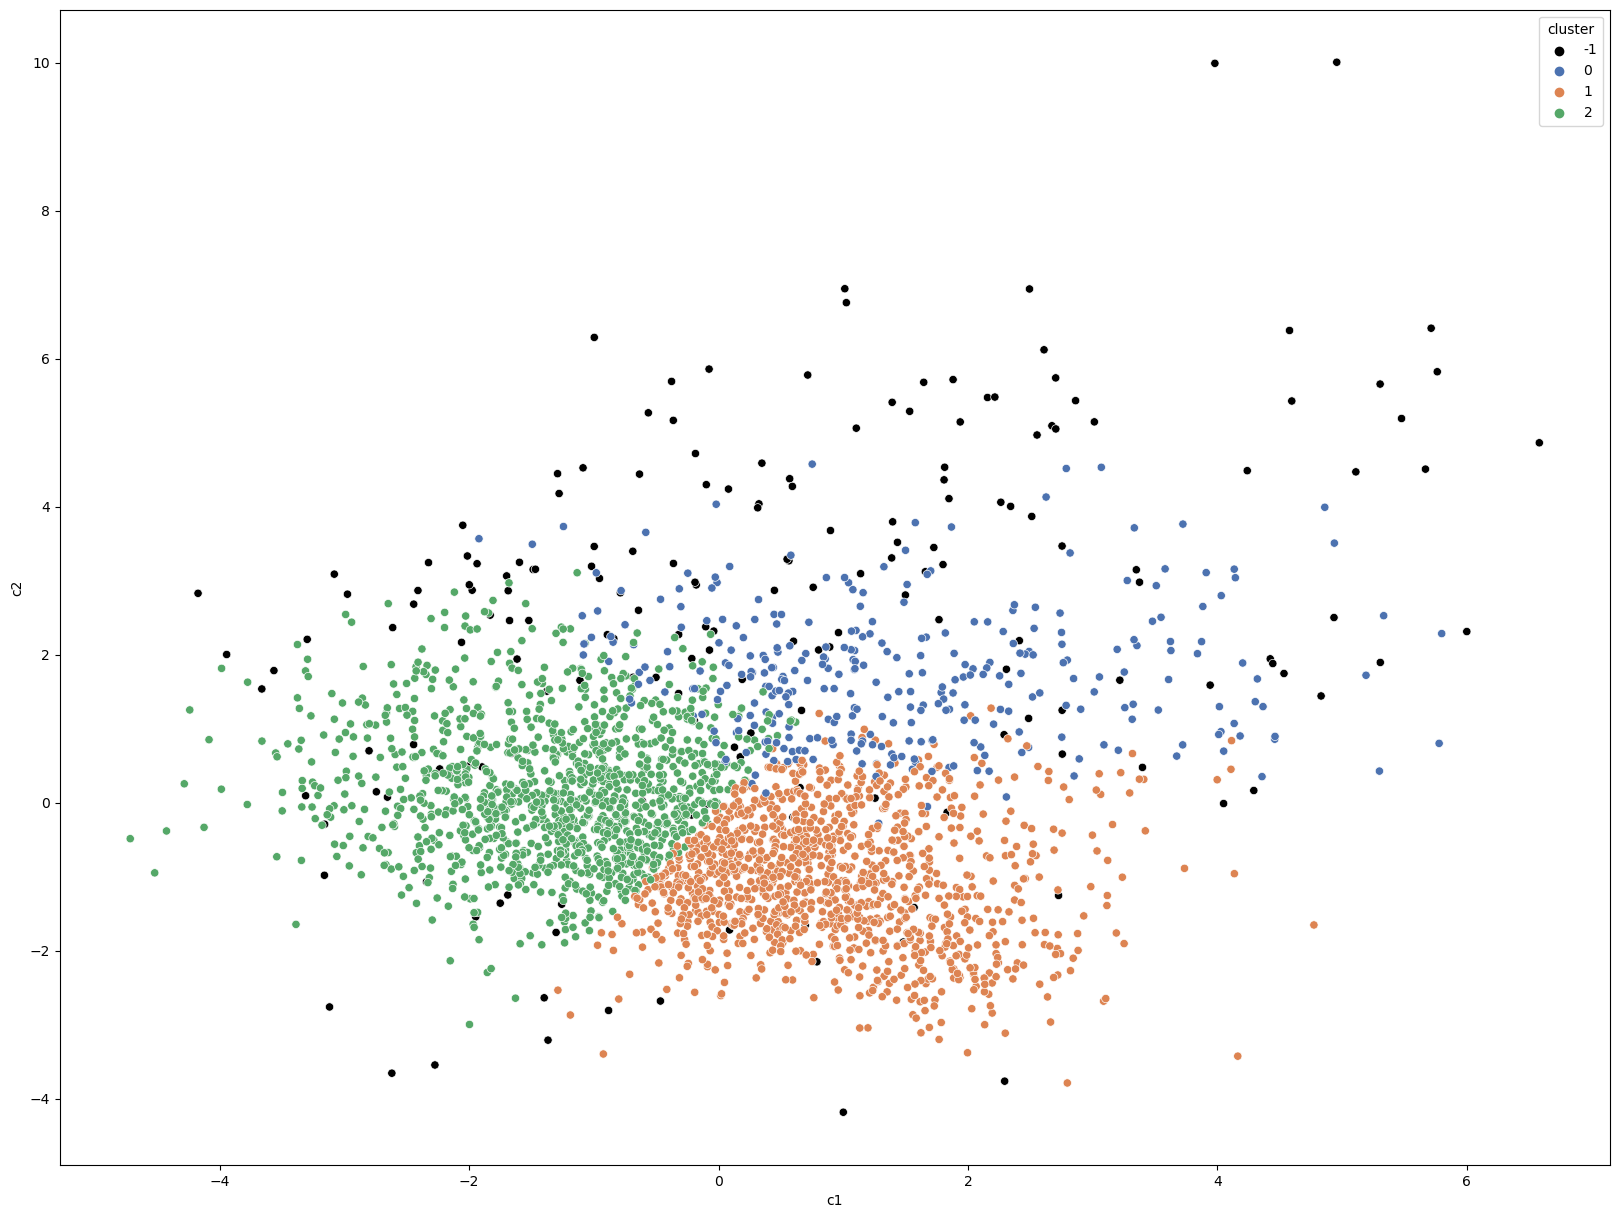

In [317]:
plt.figure(figsize=(20,15));


sns.scatterplot(data=pca_df[pca_df['cluster_db']==-1], 
                x='c1', 
                y='c2', 
                hue='cluster_db', markers='nome_municipio', palette=['k']);

sns.scatterplot(data=pca_df[pca_df['cluster_db']!=-1], 
                x='c1', 
                y='c2', 
                hue='cluster', markers='nome_municipio', palette='deep');